In [ ]:
library(tidyverse)
library(stringr)
library(ggplot2)
library(repr)

In [255]:
df = read_csv('../data/billboard-spotify.csv')

# remove duplicates based on artist and song
# in case a song charts during the end of one year and beginning of the next
df = df[!(duplicated(df[c('artist', 'song')])),]

# calculate words per second
temp = strsplit(df$lyrics, split=" ")
df['words_per_sec'] = sapply(temp, length) / (df['duration_ms'] / 1000)

# calculate duration in minutes
df['duration_min'] = df['duration_ms'] / 1000 / 60

# create a decade column
df['decade'] = floor(df['year'] / 10) * 10

# create base artist by stripping away featured artists
df = mutate(df, artist_base = str_replace_all(artist, "\\s\\(*feat.*", ""))

glimpse(df)

Parsed with column specification:
cols(
  .default = col_double(),
  rank = col_integer(),
  song = col_character(),
  artist = col_character(),
  year = col_integer(),
  lyrics = col_character(),
  release_date = col_character(),
  spotify_album_name = col_character(),
  spotify_artist = col_character(),
  spotify_name = col_character()
)
See spec(...) for full column specifications.


Observations: 4,899
Variables: 28
$ rank               <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...
$ song               <chr> "wooly bully", "i cant help myself sugar pie hon...
$ artist             <chr> "sam the sham and the pharaohs", "four tops", "t...
$ year               <int> 1965, 1965, 1965, 1965, 1965, 1965, 1965, 1965, ...
$ lyrics             <chr> "sam the sham miscellaneous wooly bully wooly bu...
$ acousticness       <dbl> 0.7130, 0.2040, 0.0348, 0.4850, 0.5040, 0.6950, ...
$ danceability       <dbl> 0.582, 0.686, 0.725, 0.510, 0.390, 0.495, 0.534,...
$ duration_ms        <dbl> 140867, 163680, 222813, 155960, 225227, 183120, ...
$ energy             <dbl> 0.575, 0.714, 0.853, 0.565, 0.309, 0.629, 0.725,...
$ explicit           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ instrumentalness   <dbl> 3.66e-06, 0.00e+00, 1.27e-01, 0.00e+00, 0.00e+00...
$ key                <dbl> 7, 0, 2, 1, 1, 4, 6, 9, 11, 0, 1, 11, 6, 1, 1, 6...
$ liveness        

# Artist diversity by year
There appears to be a slight downward trend of number of unique artists over time, though it is hard to say given the relatively few data points. 

In [50]:
nunique_artists_year = df %>% 
                        group_by(year) %>%
                        summarize(nunique = n_distinct(artist_base))

options(repr.plot.width = 16, repr.plot.height = 6)
ggplot(nunique_artists_year, aes(x = year, y = nunique), fill='black') + 
    geom_line() + 
    ylab('Number of unique artists')

# Top artists from 1965 to 2015

In [70]:
top_artists = df %>%
                group_by(artist_base) %>%
                summarize(num_singles = n()) %>%
                arrange(desc(num_singles))
top_artists = top_artists[0:30,]

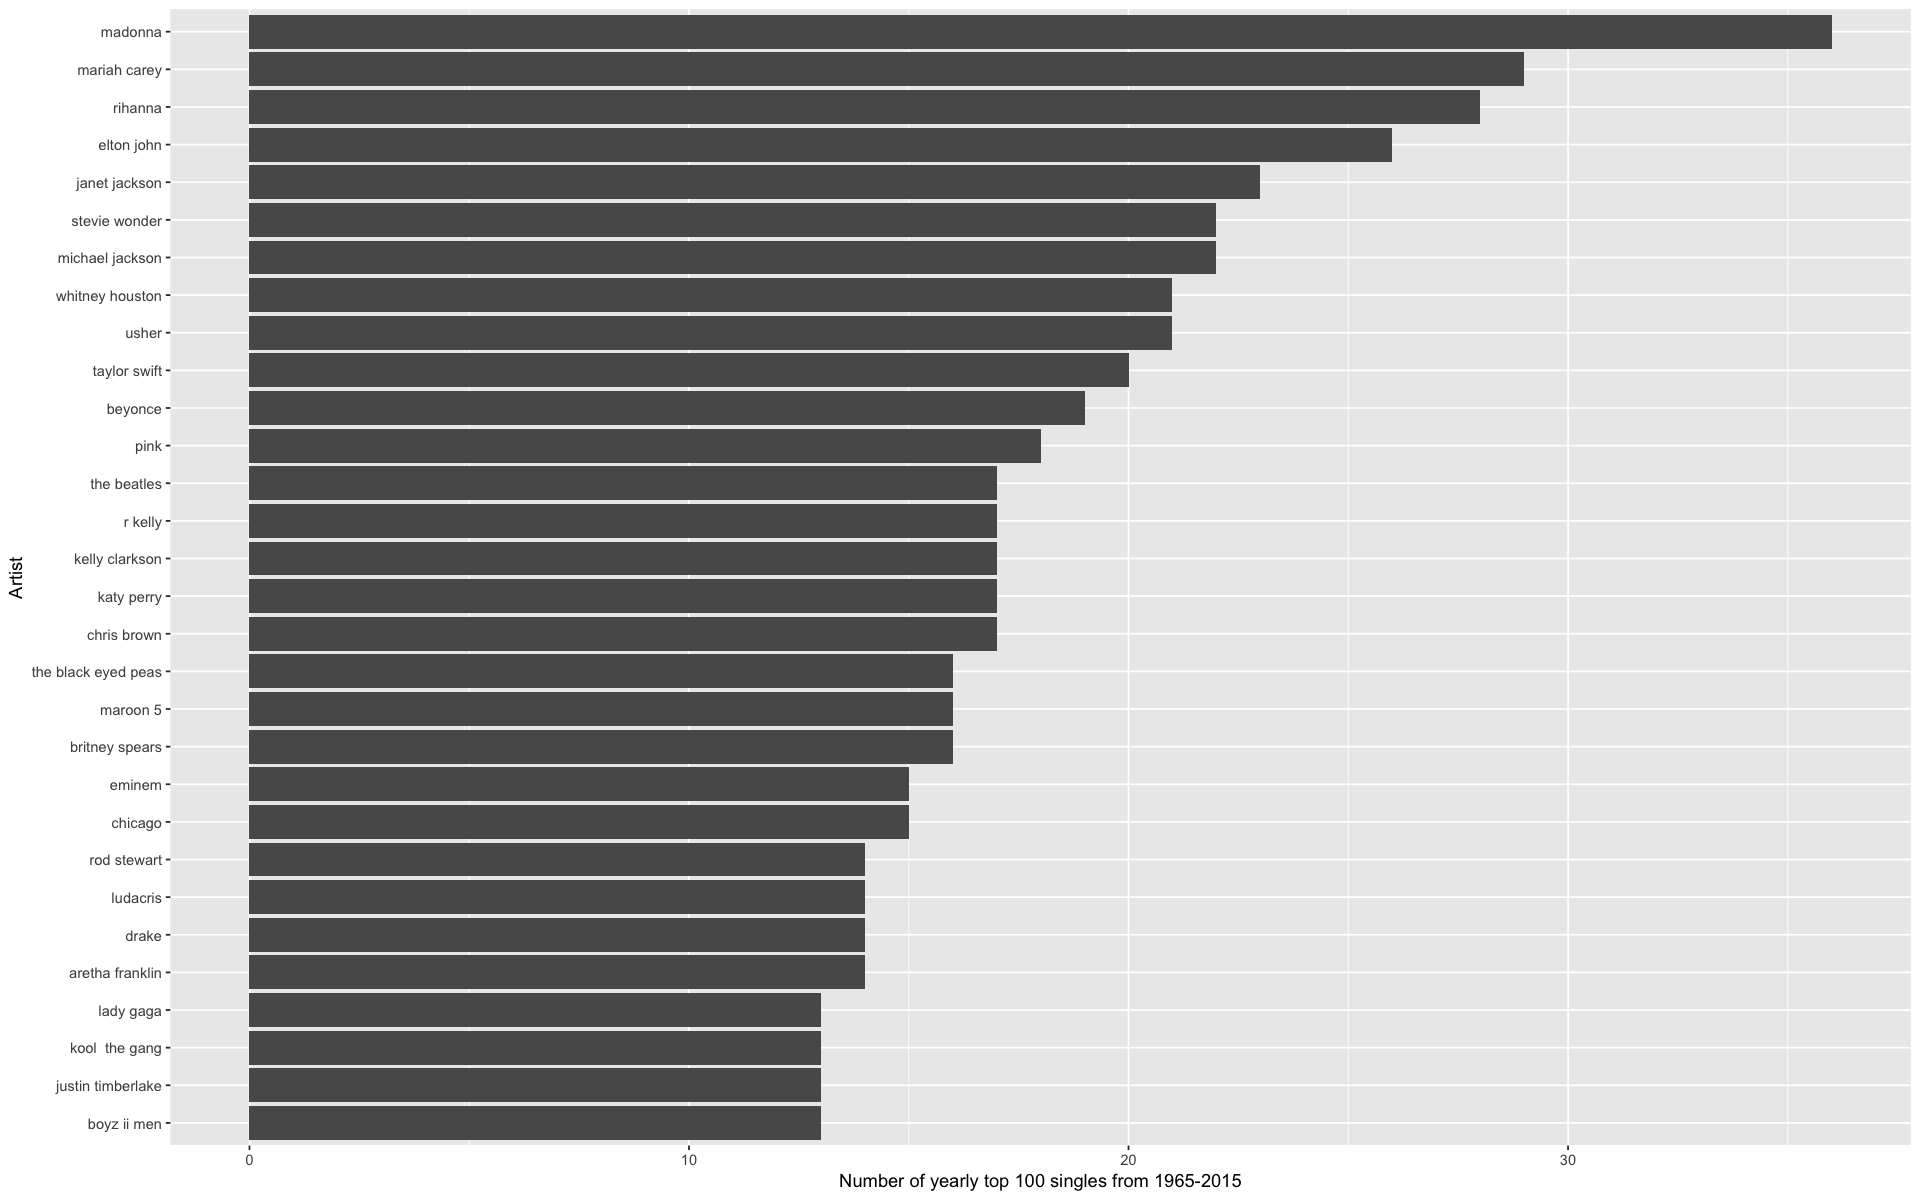

In [101]:
options(repr.plot.width = 16, repr.plot.height = 10)
ggplot(top_artists, aes(x = reorder(artist_base, num_singles), y = num_singles)) +
    geom_col() + 
    coord_flip() +
    xlab('Artist') +
    ylab('Number of yearly top 100 singles from 1965-2015')

# Artist collaboration over time
A collaboration is counted when the "artist" value for a track includes additional information of the form "featuring/feat. blah blah blah." The increase in collaborations over time makes sense given that the music industry is shrinking, and more artists are forced to work together to generate sufficient star-power wattage for their music. The increase in popularity of EDM and the practice of remixing other artists' work may also account for the observed trend.

In [79]:
collaborations = df %>%
                    mutate(is_collab = str_detect(artist, 'feat')) %>%
                    group_by(year) %>%
                    summarize(num_collaborations = sum(is_collab))

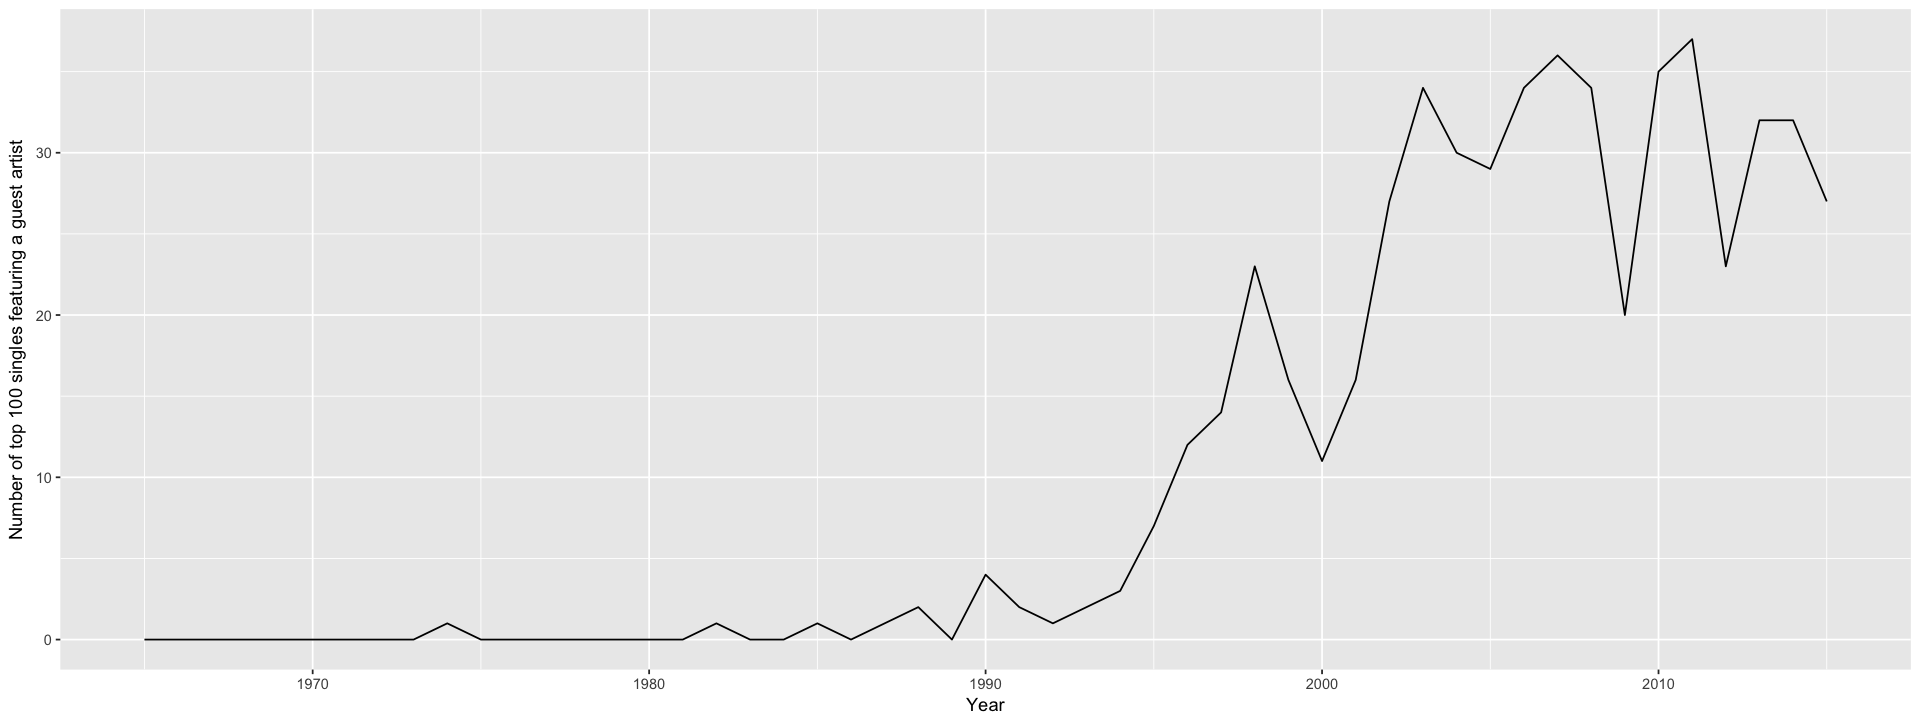

In [86]:
options(repr.plot.width = 16, repr.plot.height = 6)
ggplot(collaborations, aes(x = year, y = num_collaborations)) +
    geom_line() +
    xlab('Year') +
    ylab('Number of top 100 singles featuring a guest artist')

# Most collaborative artists

In [95]:
collaborative_artists = df %>%
                    mutate(is_collab = str_detect(artist, 'feat')) %>%
                    group_by(artist_base) %>%
                    summarize(num_collaborations = sum(is_collab)) %>%
                    arrange(desc(num_collaborations))
collaborative_artists = collaborative_artists[0:20,]

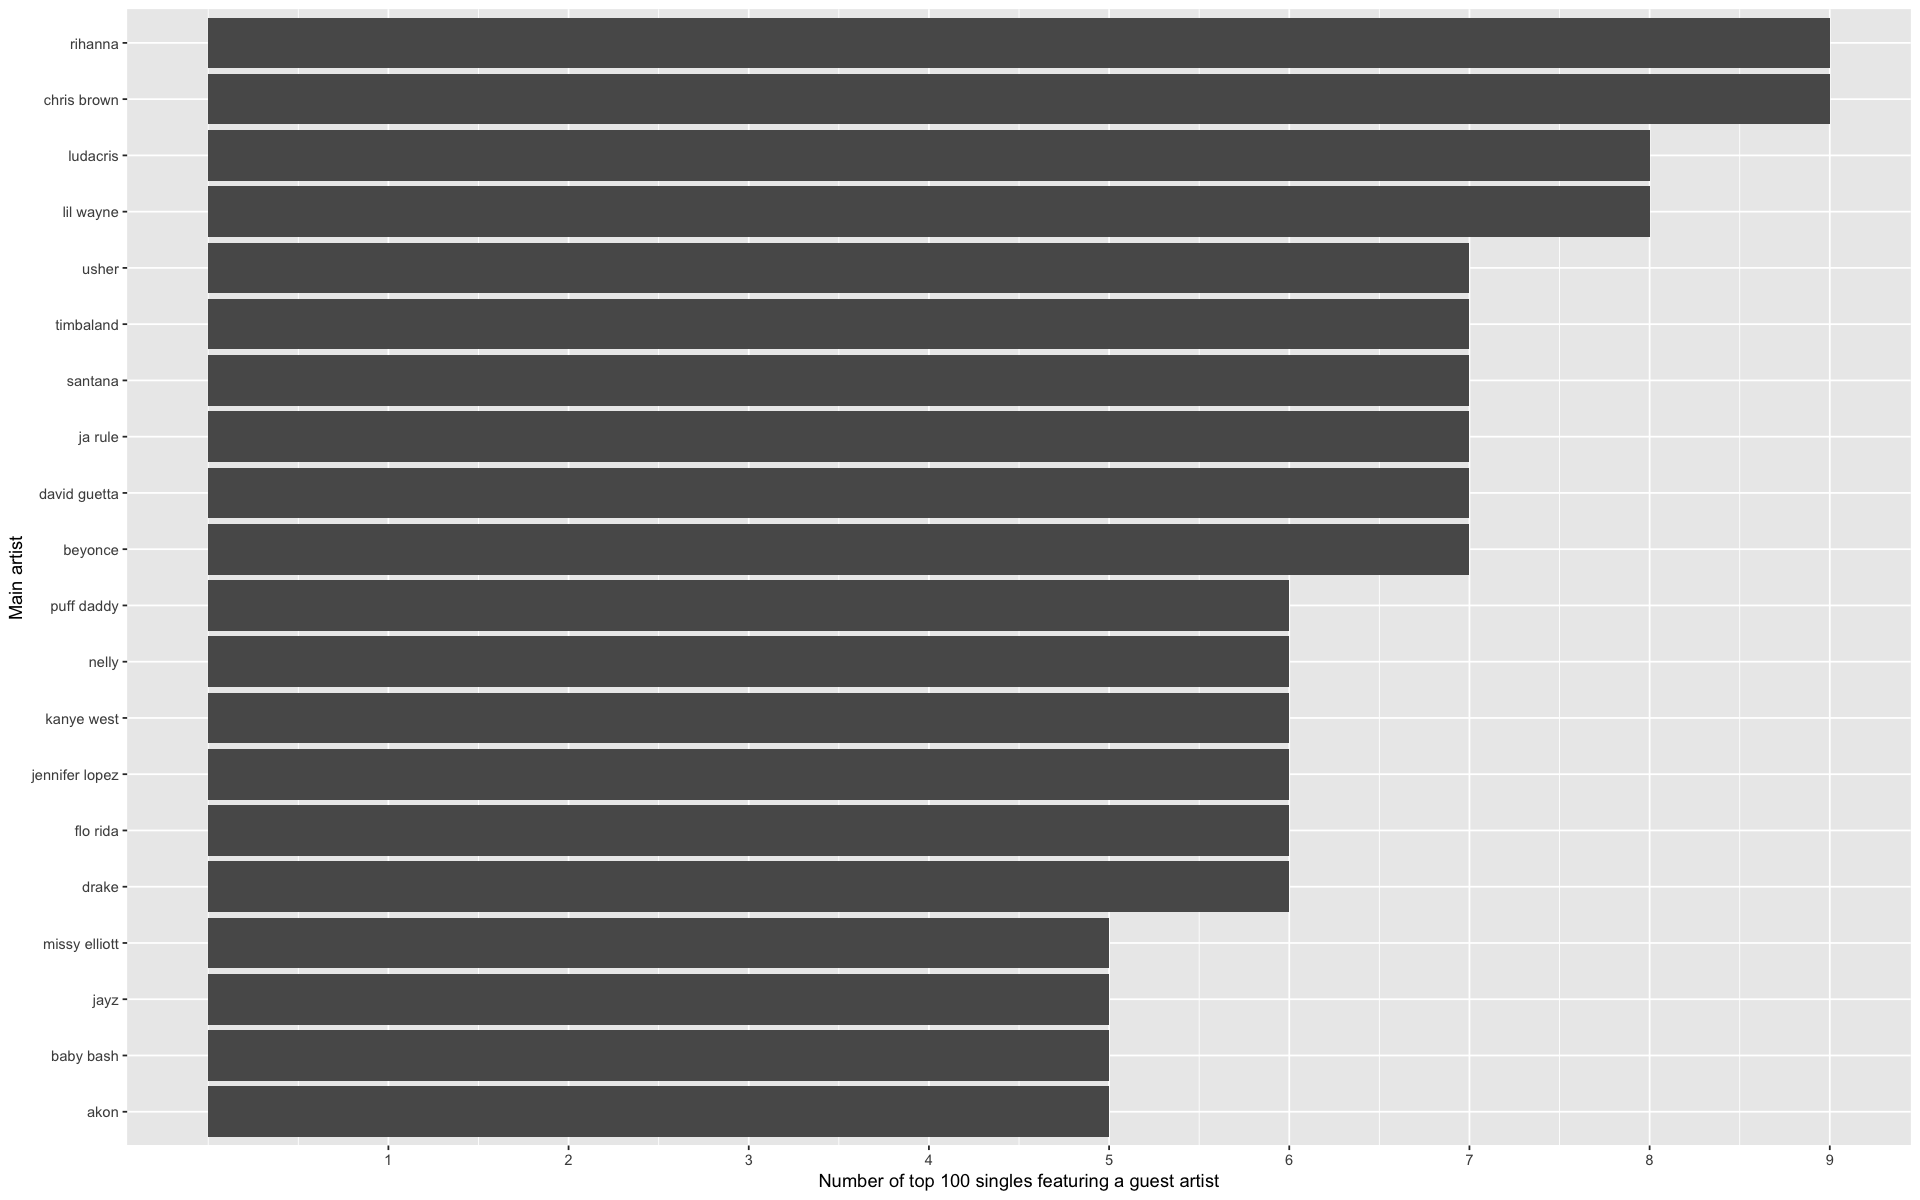

In [116]:
options(repr.plot.width = 16, repr.plot.height = 10)
ggplot(collaborative_artists, aes(x = reorder(artist_base, num_collaborations),
                                              y = num_collaborations)) +
    geom_col() +
    xlab('Main artist') +
    ylab('Number of top 100 singles featuring a guest artist') +
    scale_y_continuous(breaks=1:9, labels=1:9) + 
    coord_flip()

# Most featured artists

In [187]:
matches = str_match(as.list(df['artist'])$artist, 'featuring\\s(.*)')
matches = matches[, 2]
matches = matches[!is.na(matches)]
matches = as_tibble(matches)

featured_artists = matches %>%
                    group_by(value) %>%
                    summarize(num_features = n()) %>%
                    arrange(desc(num_features))
featured_artists = featured_artists[1:20,]

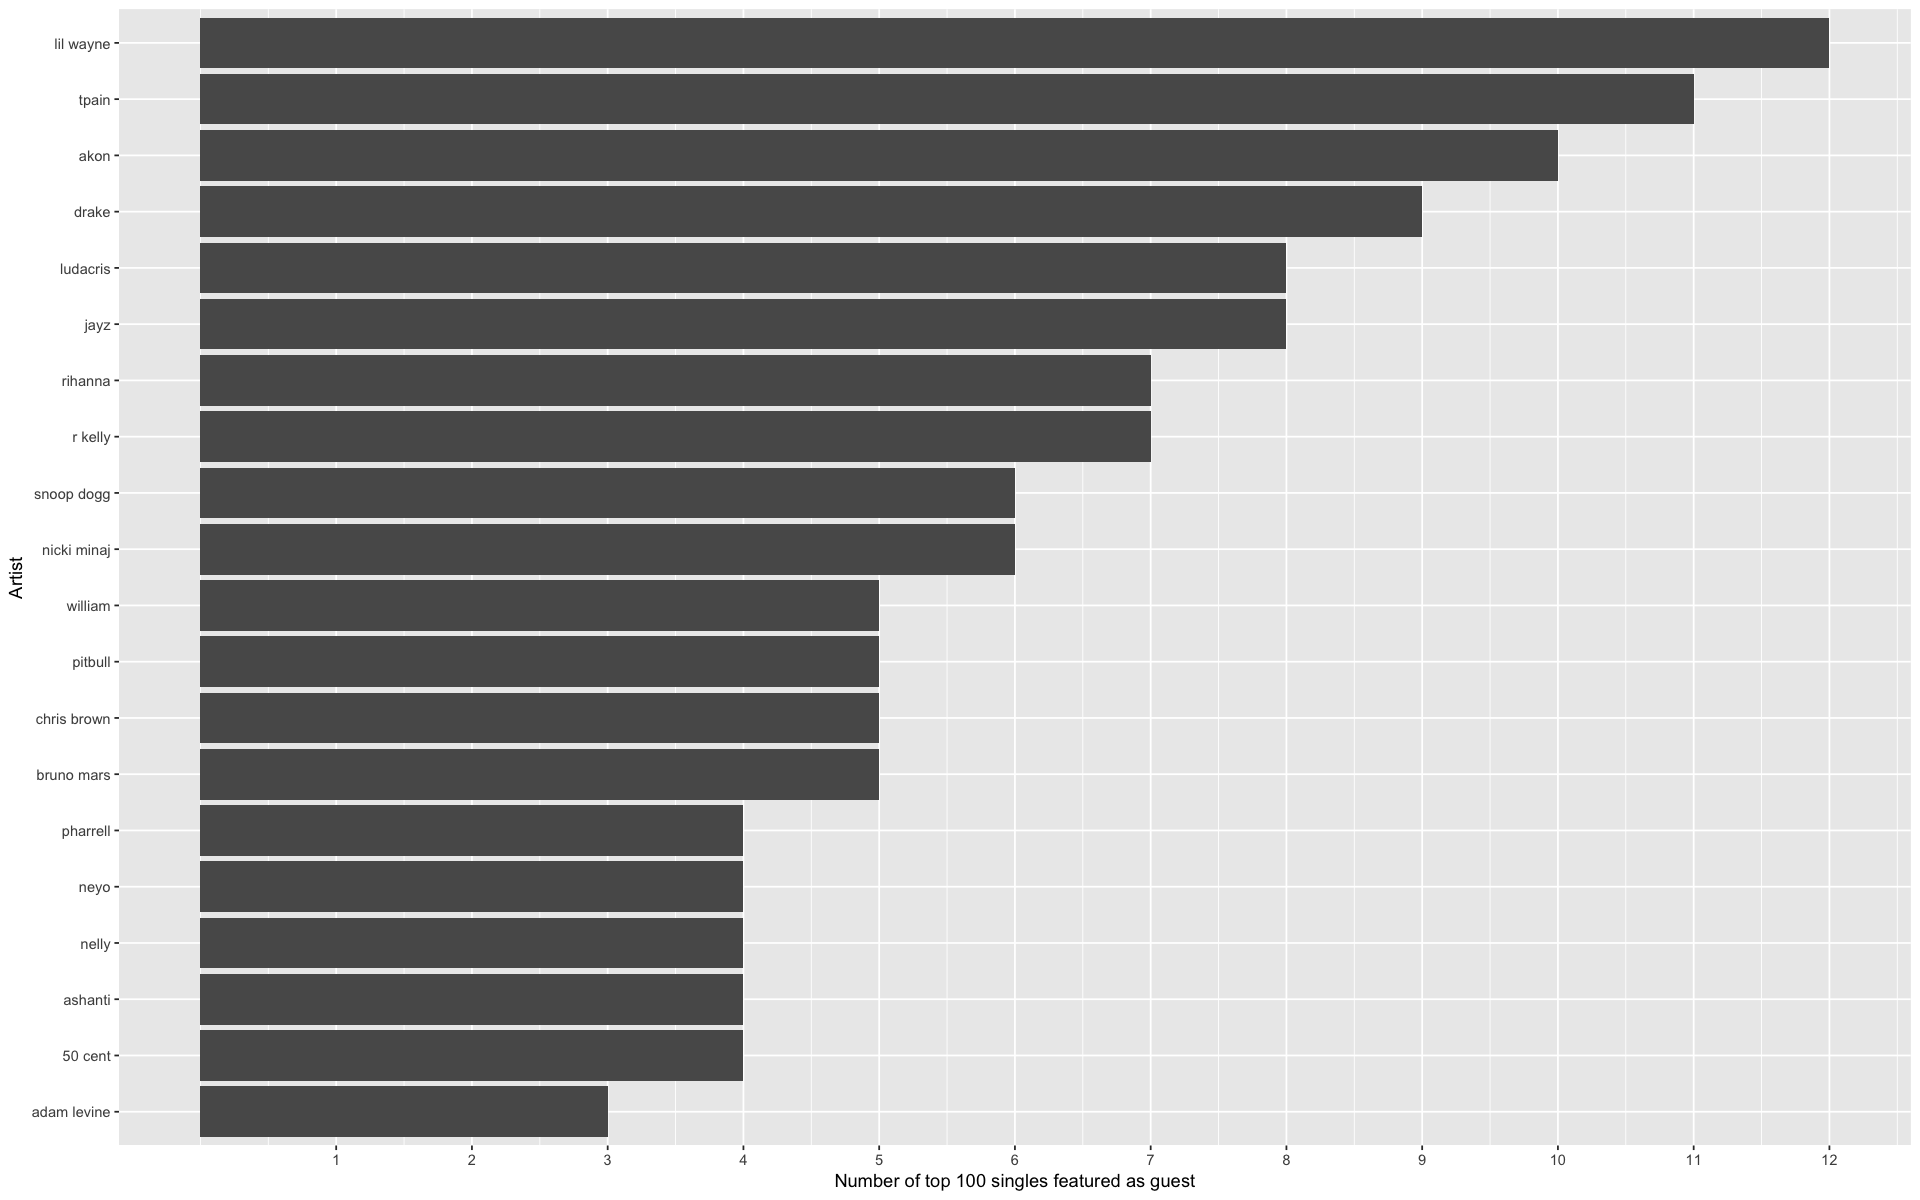

In [191]:
options(repr.plot.width = 16, repr.plot.height = 10)
ggplot(featured_artists, aes(x = reorder(value, num_features),
                                              y = num_features)) +
    geom_col() +
    xlab('Artist') +
    ylab('Number of top 100 singles featured as guest') +
    scale_y_continuous(breaks=1:12, labels=1:12) + 
    coord_flip()

# Most verbose artists

In [261]:
verbose_artists = df %>%
                    group_by(artist_base) %>%
                    summarize(mean_wps = mean(words_per_sec)) %>%
                    arrange(desc(mean_wps))
verbose_artists = verbose_artists[1:20,]

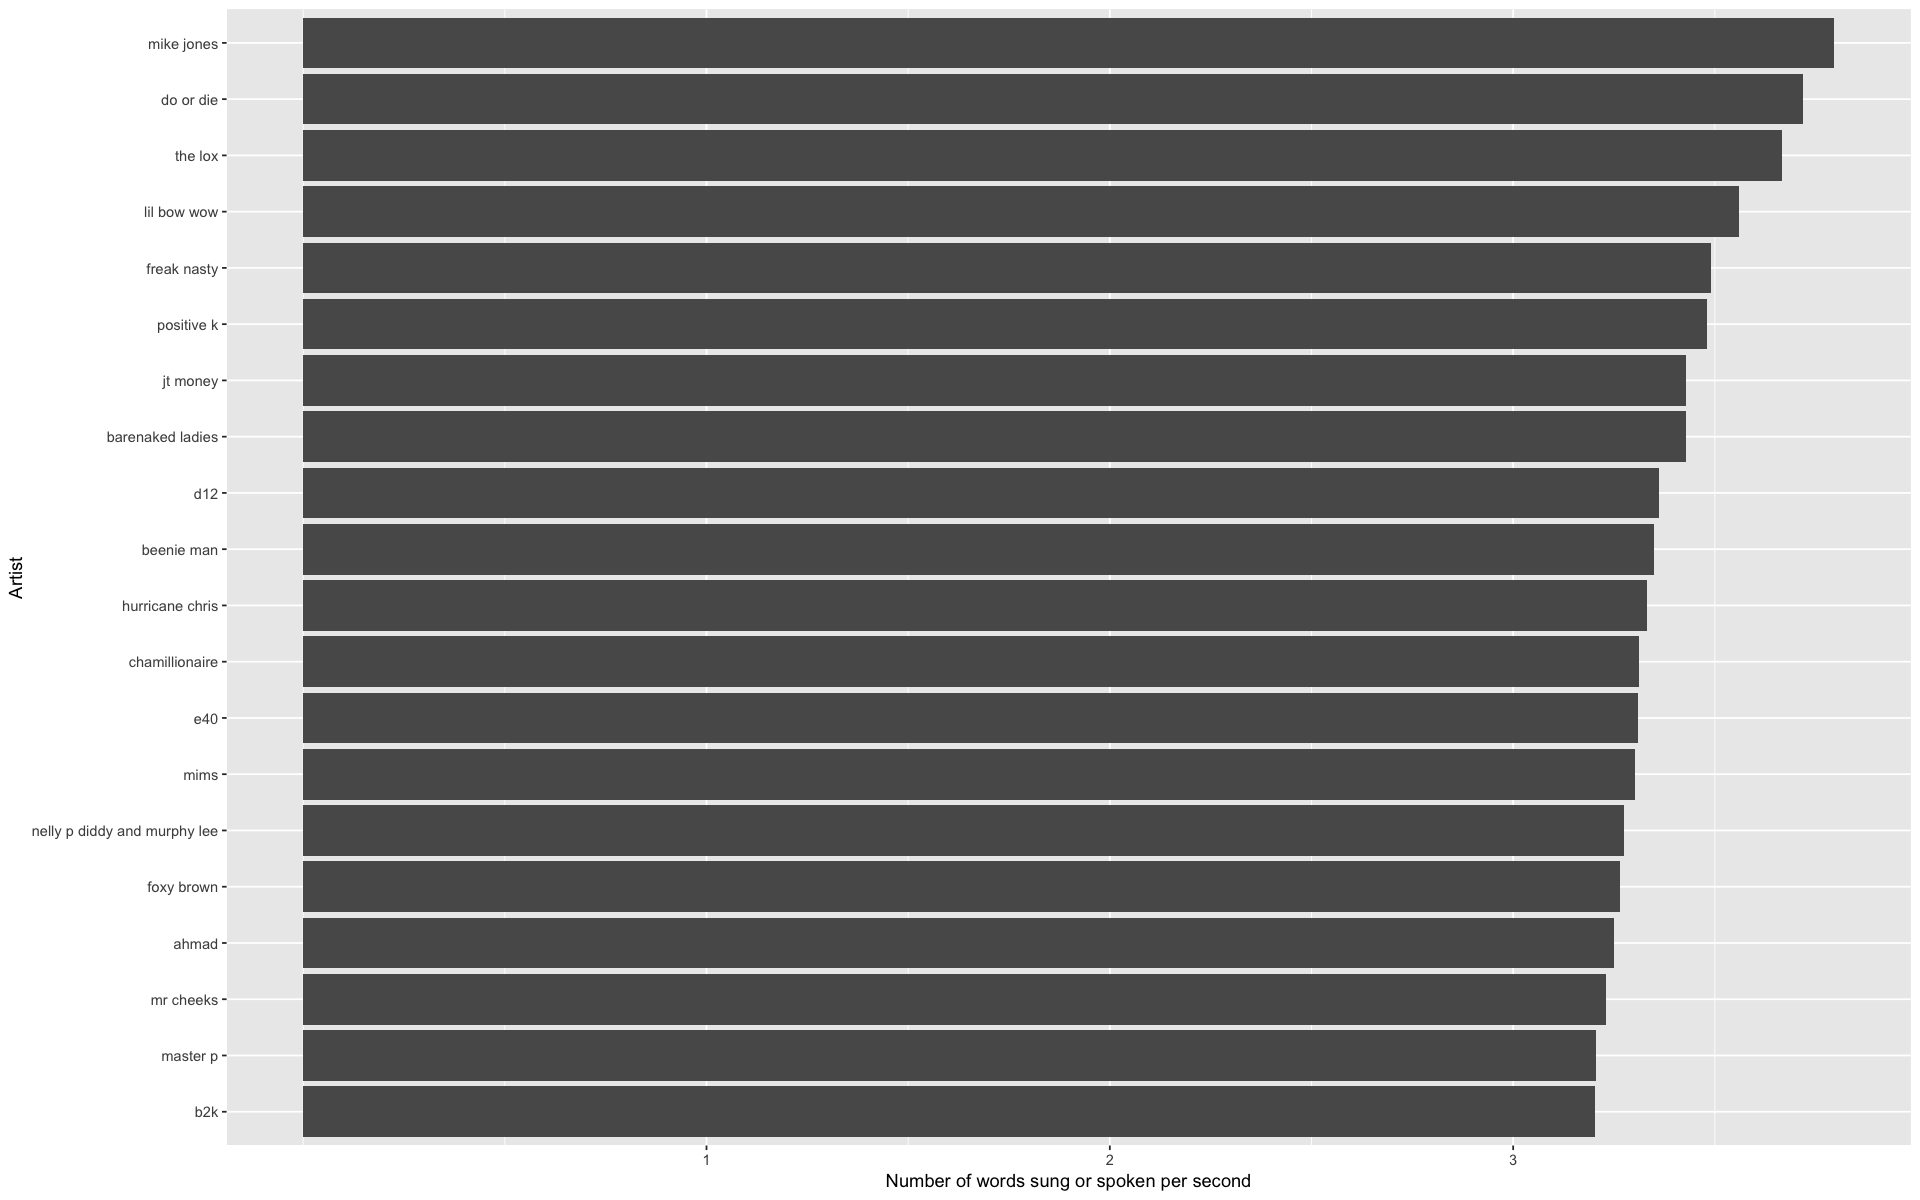

In [264]:
options(repr.plot.width = 16, repr.plot.height = 10)
ggplot(verbose_artists, aes(x = reorder(artist_base, mean_wps),
                                              y = mean_wps)) +
    geom_col() +
    xlab('Artist') +
    ylab('Number of words sung or spoken per second') +
    scale_y_continuous(breaks=1:12, labels=1:12) + 
    coord_flip()

# Correlation heatmap dendrogram
The dendrogrammed correlation heatmap reveals some interesting aspects of the data's correlation structure.
- Popularity and year are weakly correlated. This makes intuitive sense given that the audience on Spotify are more likely to listen to more current music and that people who would enjoy the oldies probably don't even know what Spotify is.
- Loudness and year are also weakly correlated. This will be commented on in the "Misc" section.
- Loudness and energy are moderately correlated.
- Acousticness and energy are weakly anticorrelated. This could be explained by the fact that ballads and other slow music are more likely to feature acoustic instruments.
- Valance and danceability are weakly correlated. No one wants to dance to sad/angry music. But what about EDM? Might be worth investigating if this correlation holds over time.
- Words per second is weakly correlated with speechiness. Indeed, it's easier to talk fast than to sing fast.

In [212]:
columns = c('rank', 'year', 'acousticness', 'danceability', 'duration_min', 
            'energy', 'instrumentalness', 'liveness', 'loudness', 'popularity',
            'speechiness', 'tempo', 'valence', 'words_per_sec')

df_cor = df[columns]
correlation = cor(df_cor, method='pearson', use='pairwise.complete.obs')

Unable to add numerical annotations and legend to this version. We may just mention that we would have if it were possible, and include a second version (the original one made with Seaborn) in the final report.

Warning message in plot.window(...):
“"legend" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"legend" is not a graphical parameter”Warning message in title(...):
“"legend" is not a graphical parameter”

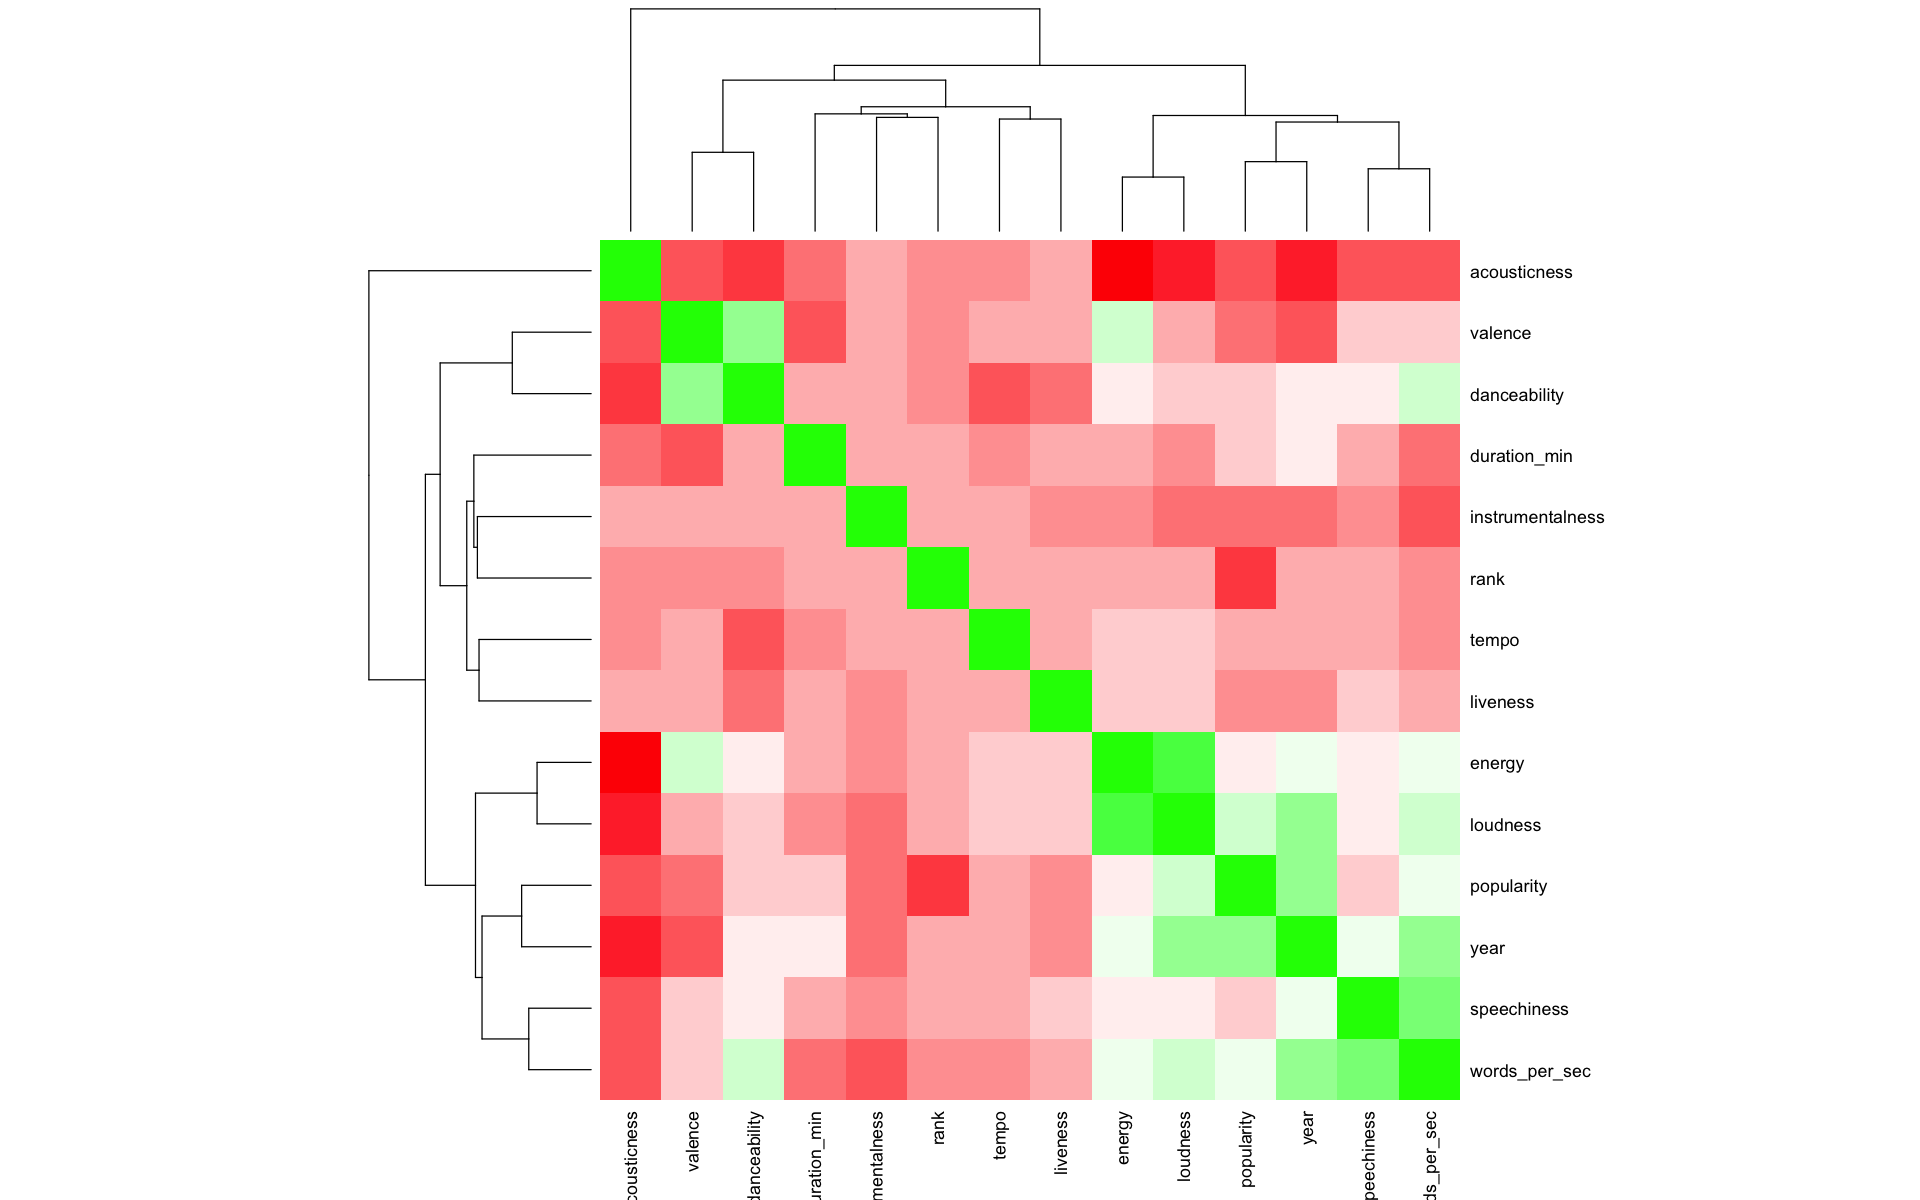

In [220]:
col = colorRampPalette(c('red', 'white', 'green'))(20)
heatmap(x = correlation, col = col, symm = TRUE, legend = 'col')

# Scatterplots of the strongest correlations and anti-correlations

### Acousticness vs Energy

Warning message:
“Removed 327 rows containing missing values (geom_point).”

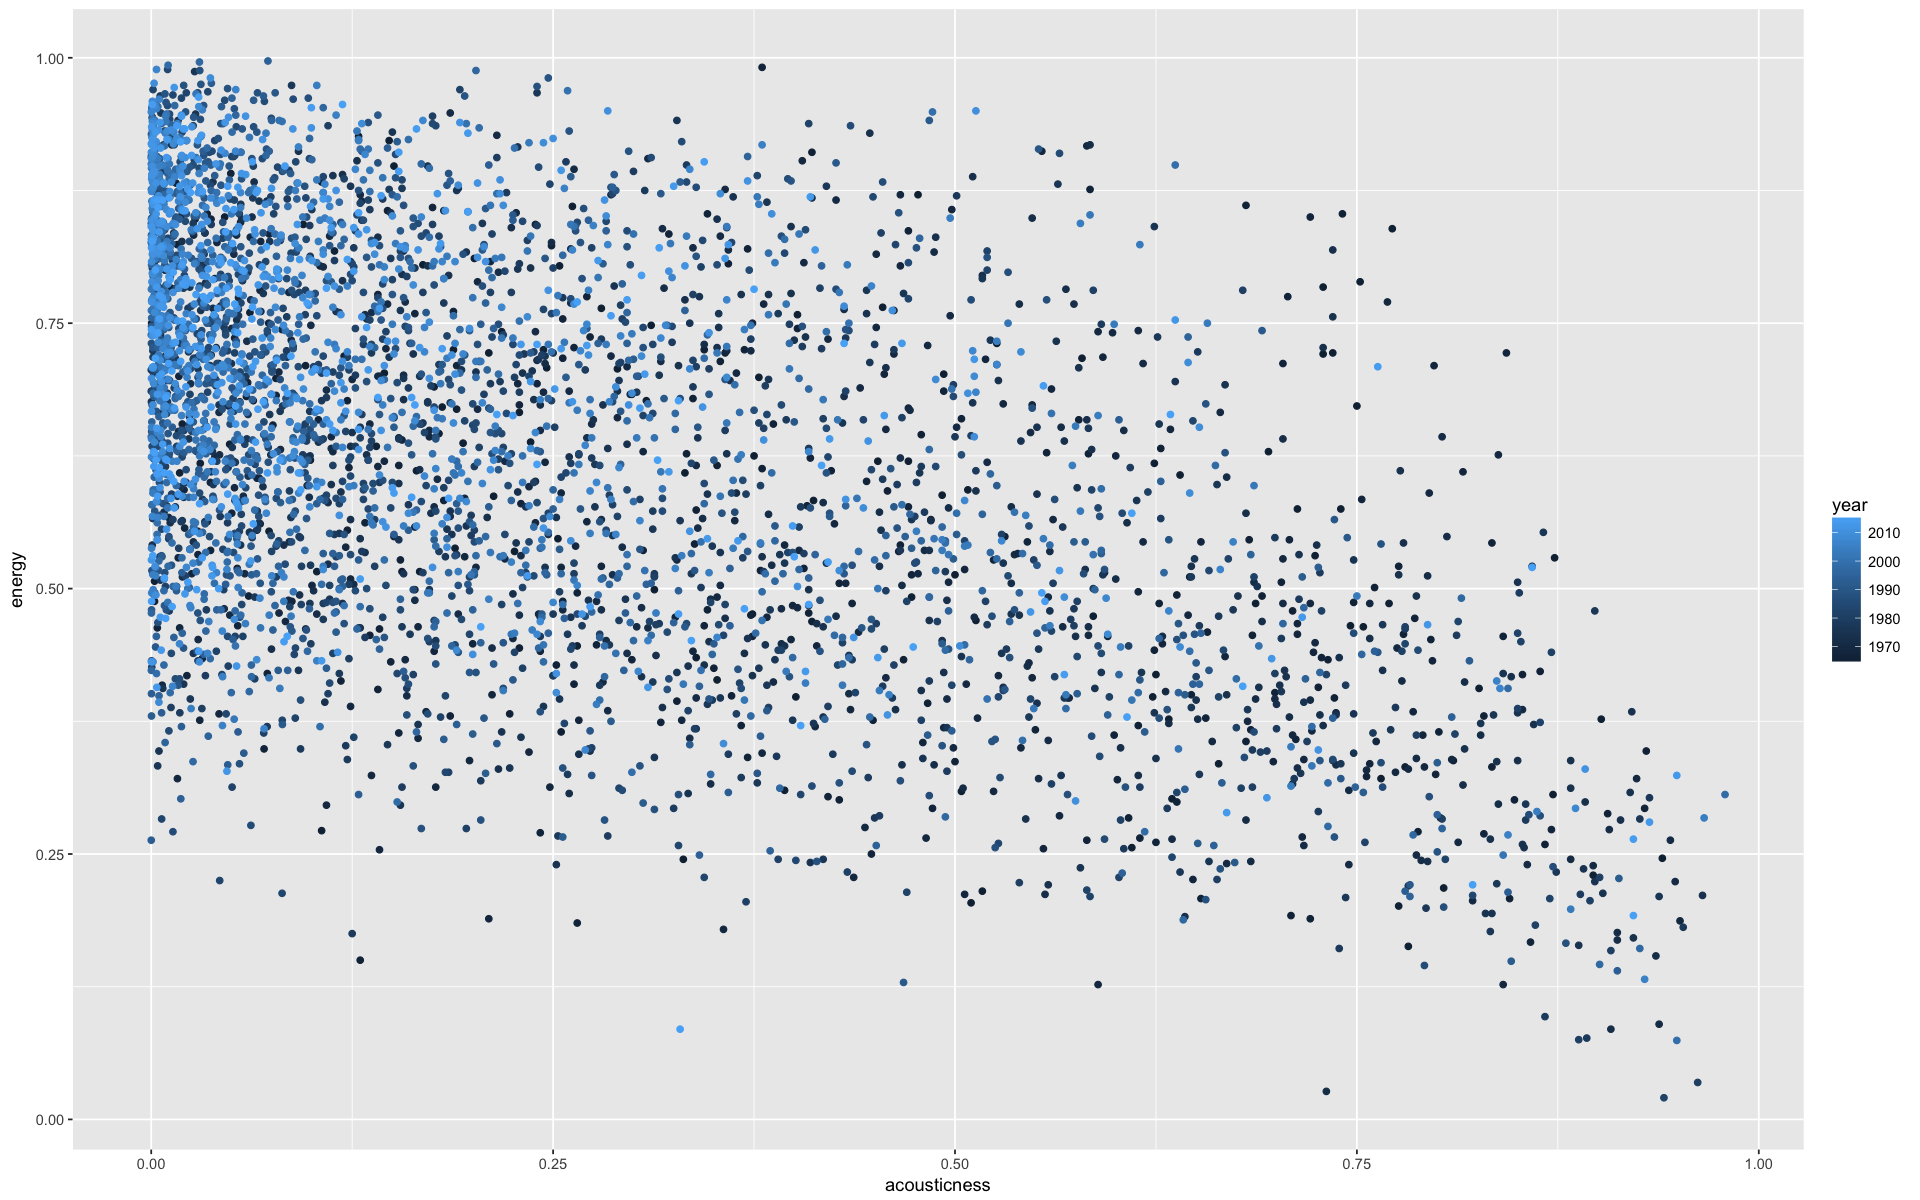

In [244]:
ggplot(df, aes(x=acousticness, y=energy, color=year)) +
    geom_point() 

Warning message:
“Removed 327 rows containing missing values (geom_point).”

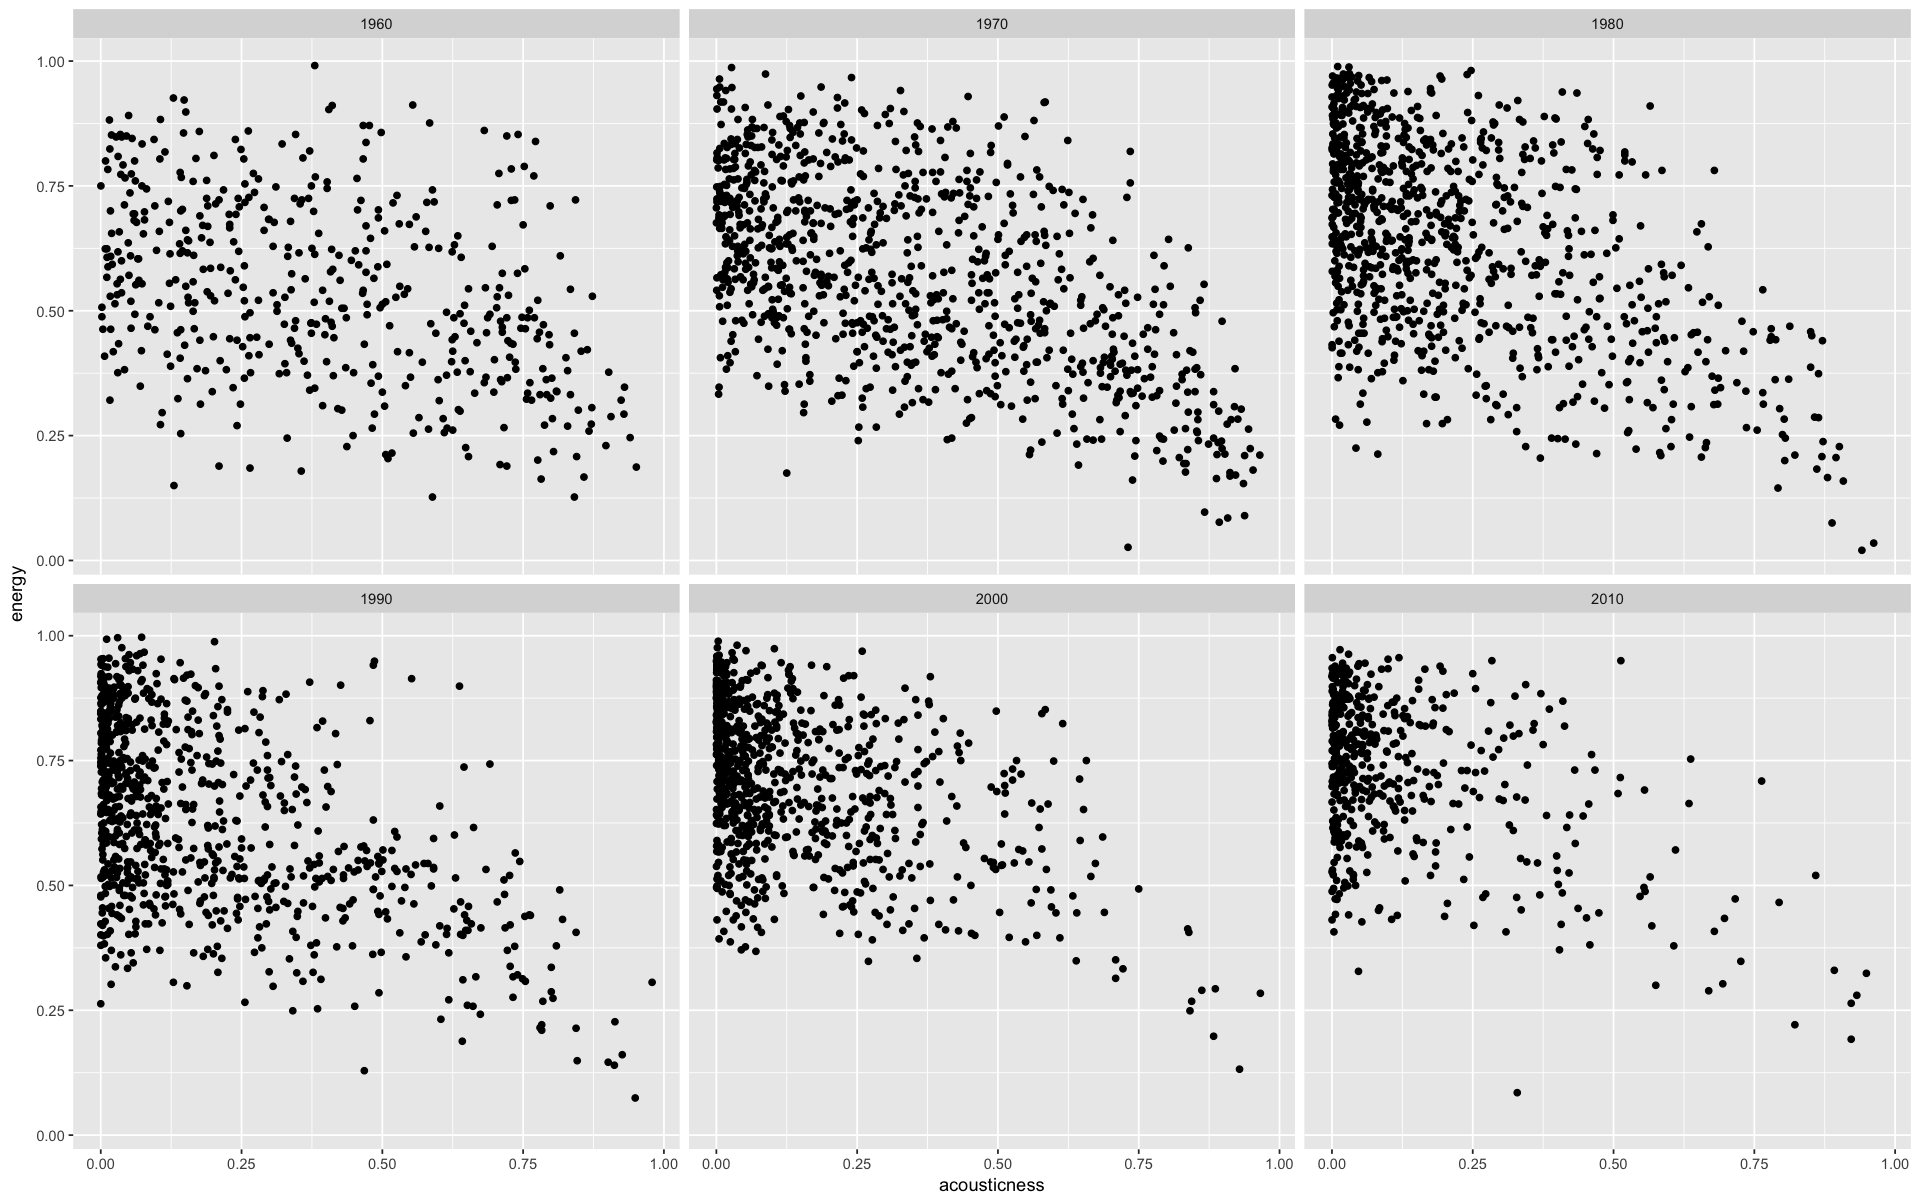

In [239]:
ggplot(df, aes(x=acousticness, y=energy)) +
    geom_point() +
    facet_wrap(~ decade)

### Danceability vs Valence

Warning message:
“Removed 327 rows containing missing values (geom_point).”

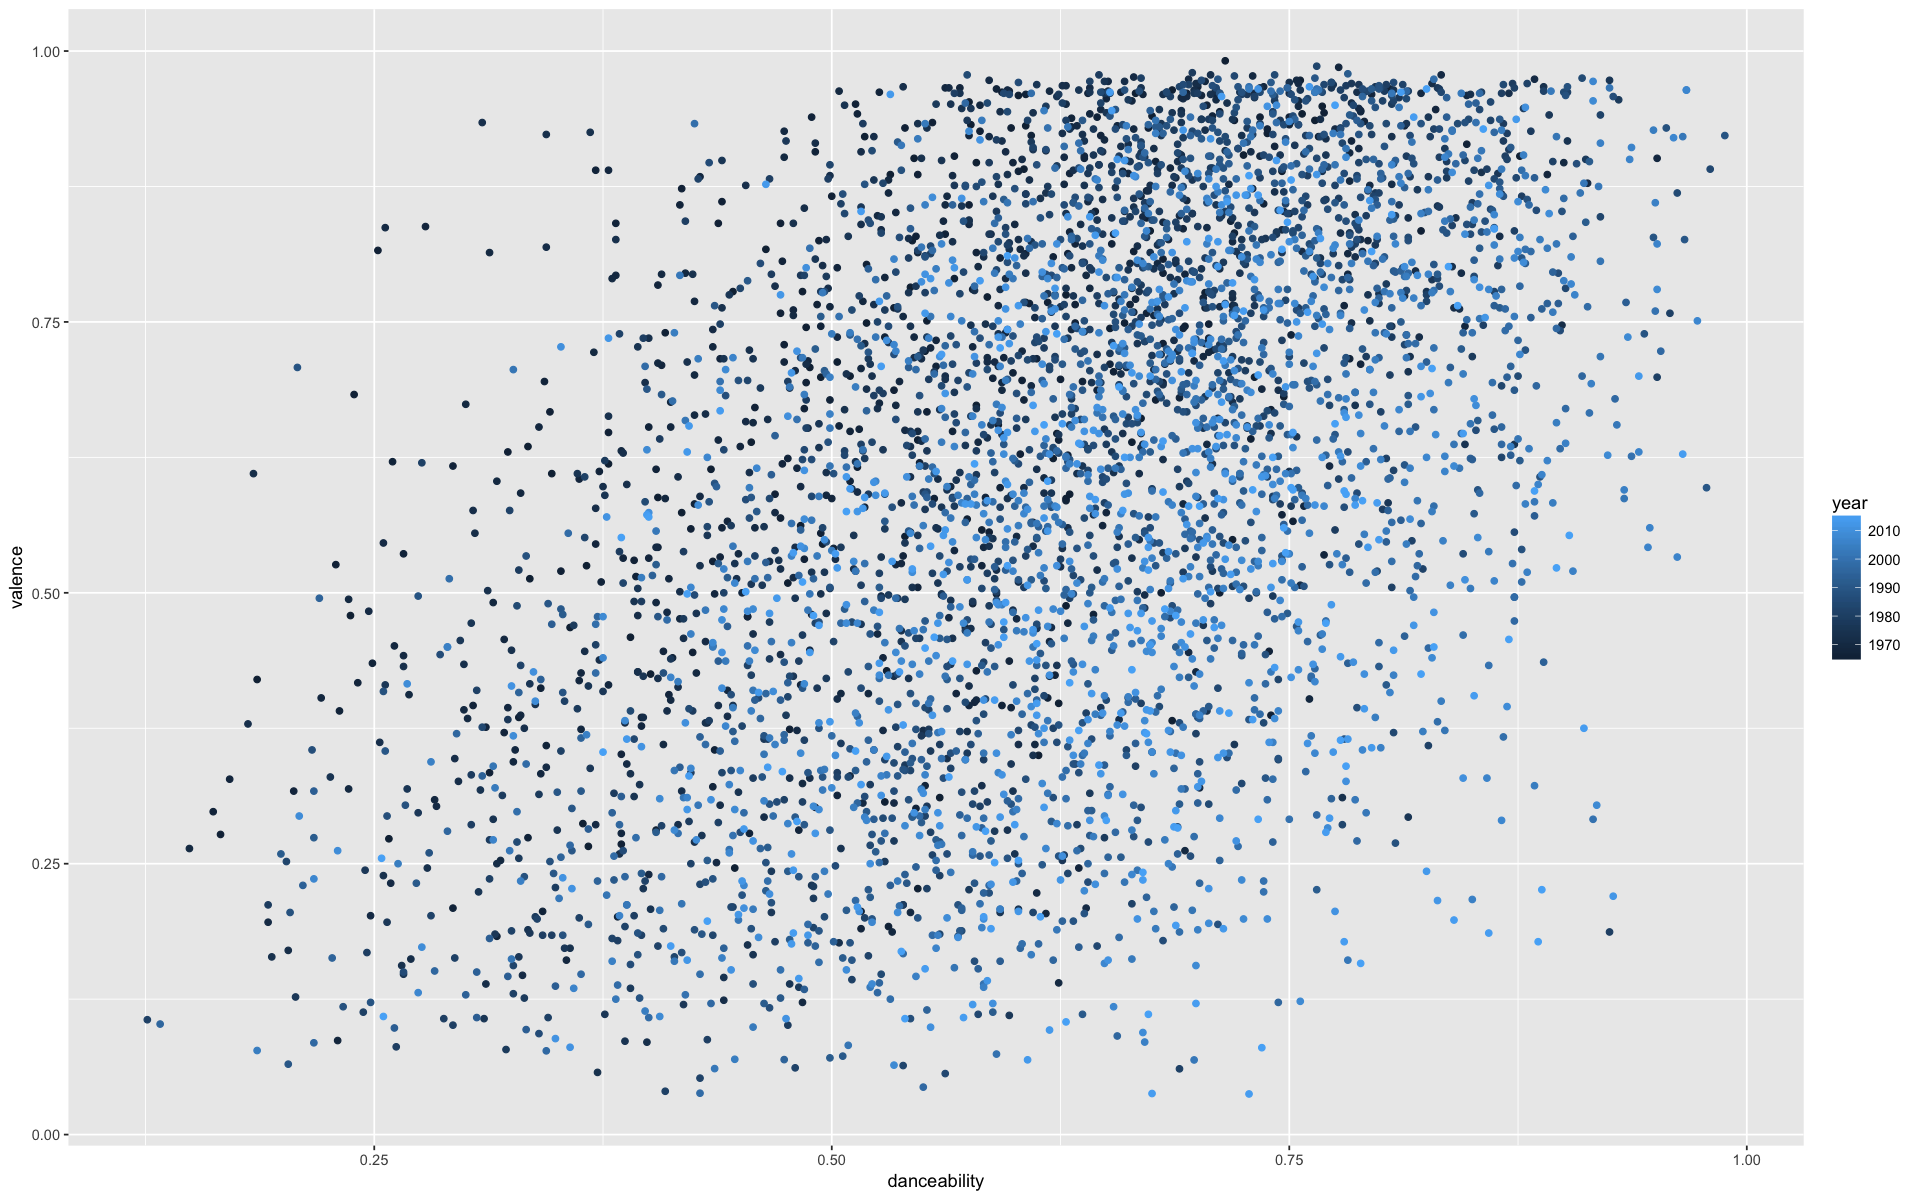

In [246]:
ggplot(df, aes(x=danceability, y=valence, color=year)) +
    geom_point() 

### Speechiness vs. Words-per-sec

Warning message:
“Removed 327 rows containing missing values (geom_point).”

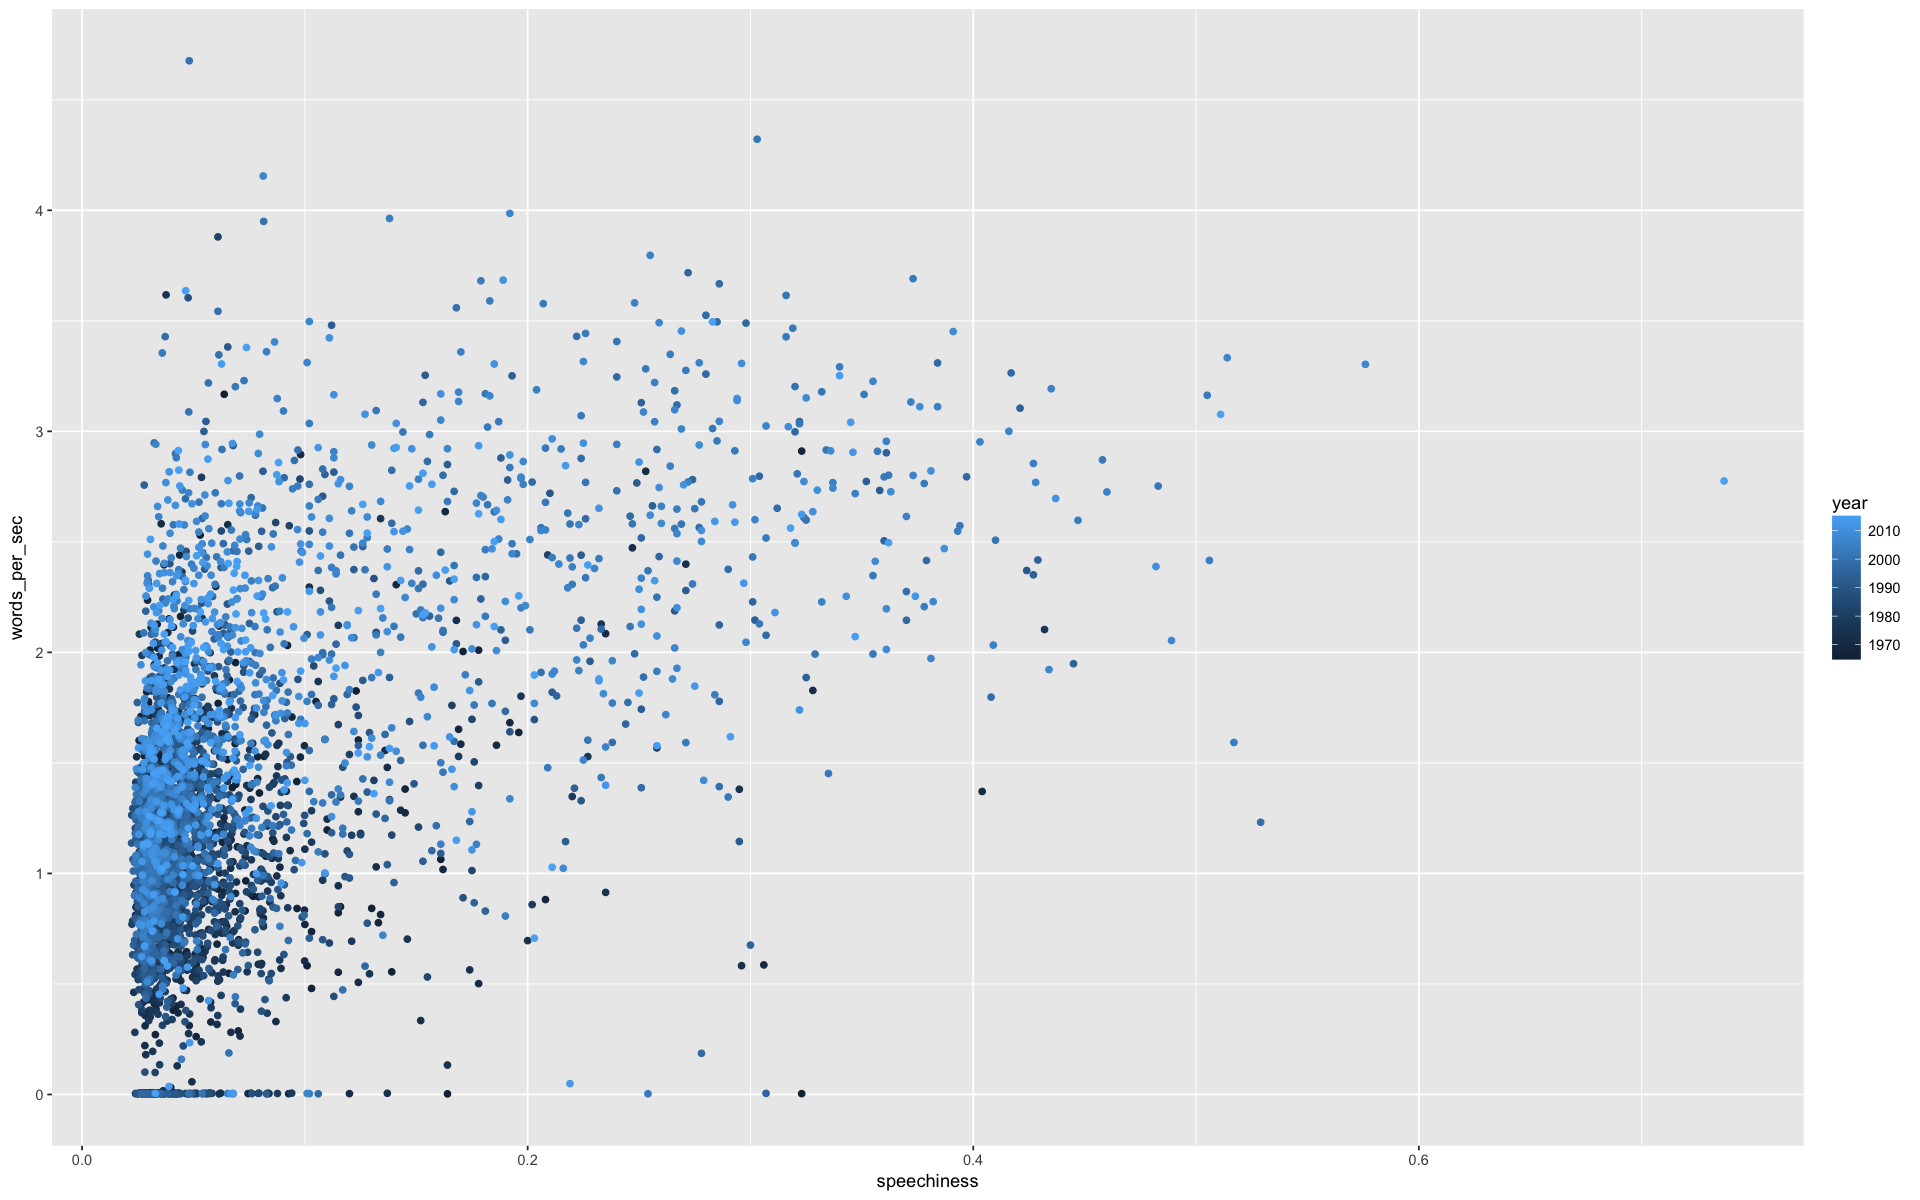

In [248]:
ggplot(df, aes(x=speechiness, y=words_per_sec, color=year)) +
    geom_point() 

Warning message:
“Removed 327 rows containing missing values (geom_point).”

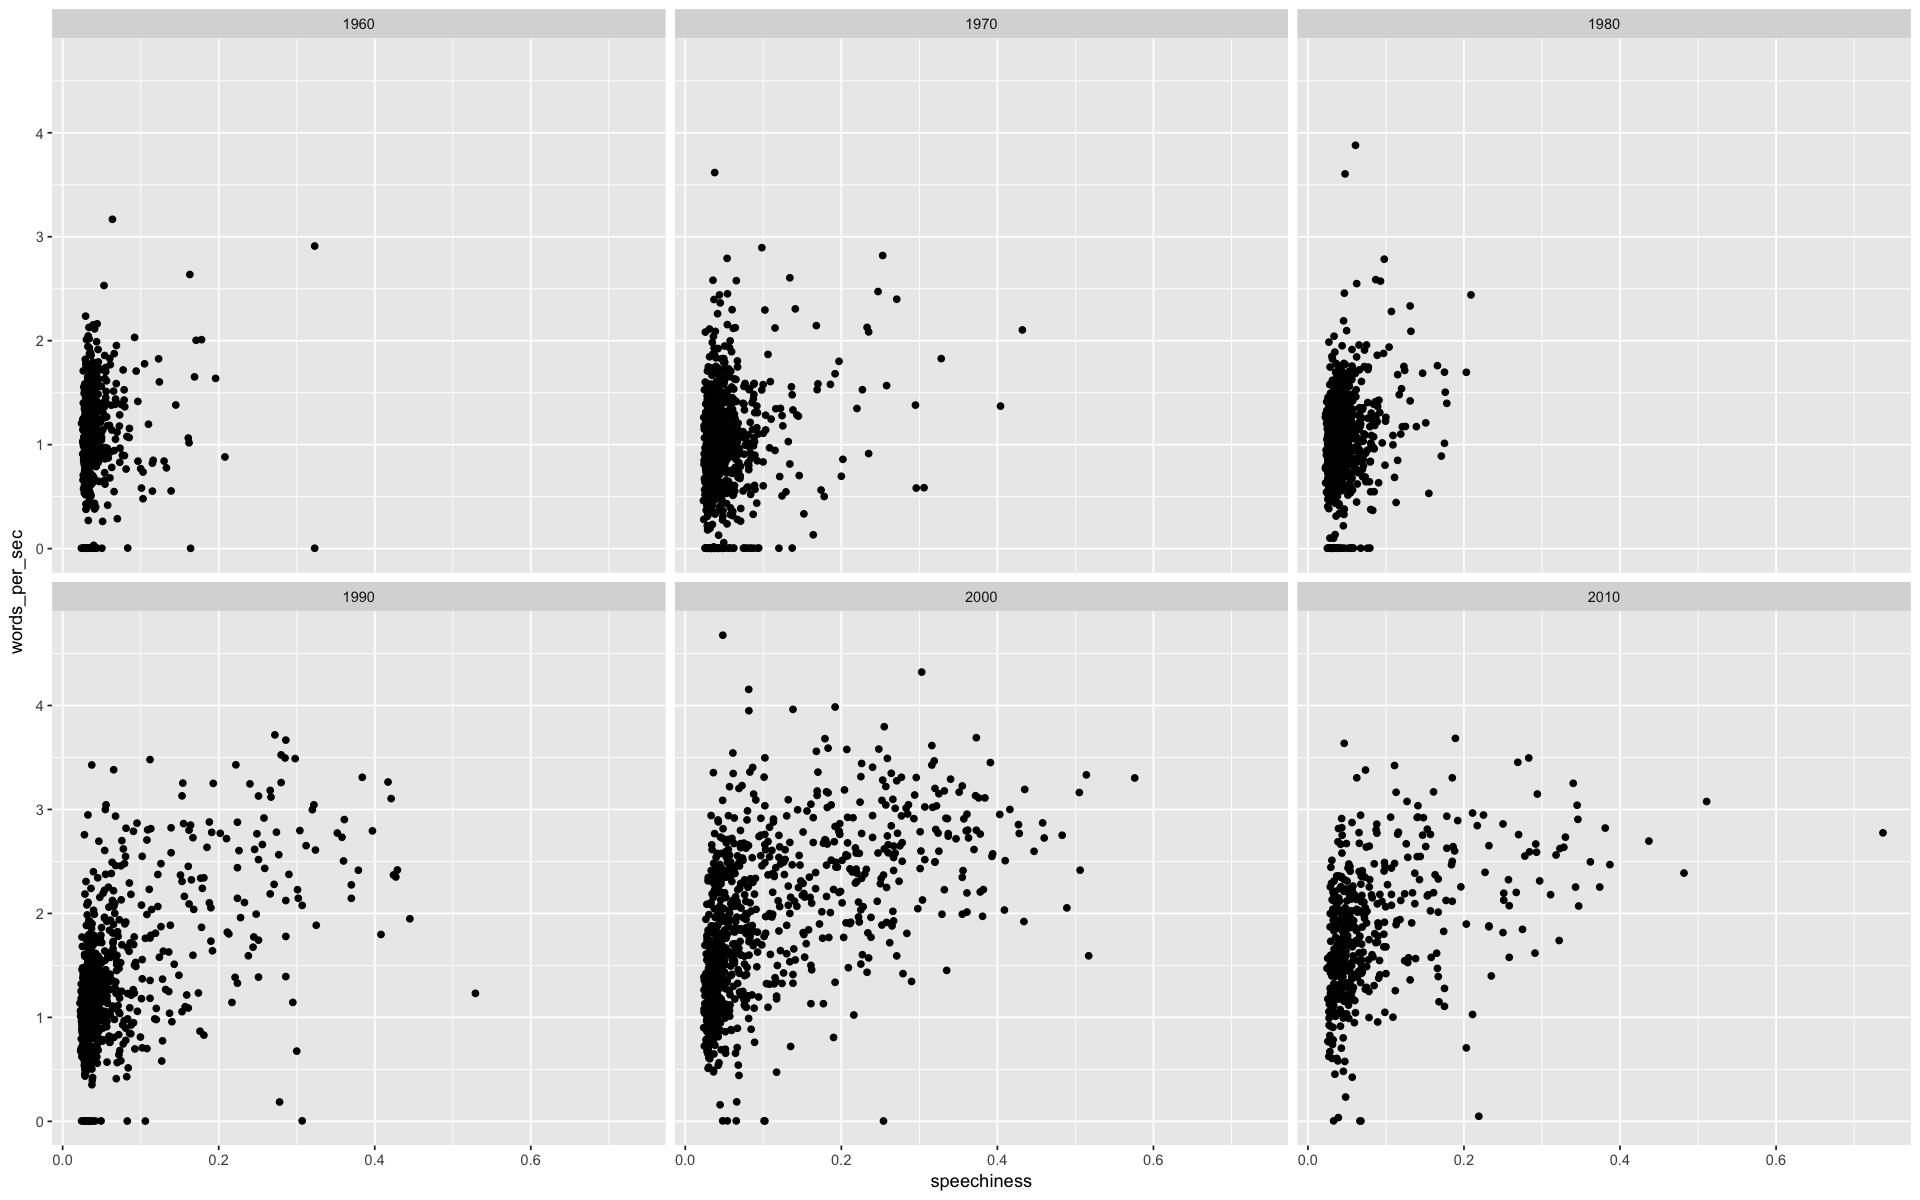

In [250]:
ggplot(df, aes(x=speechiness, y=words_per_sec)) +
    geom_point() +
    facet_wrap(~ decade)

### Energy vs Loudness

Warning message:
“Removed 327 rows containing missing values (geom_point).”

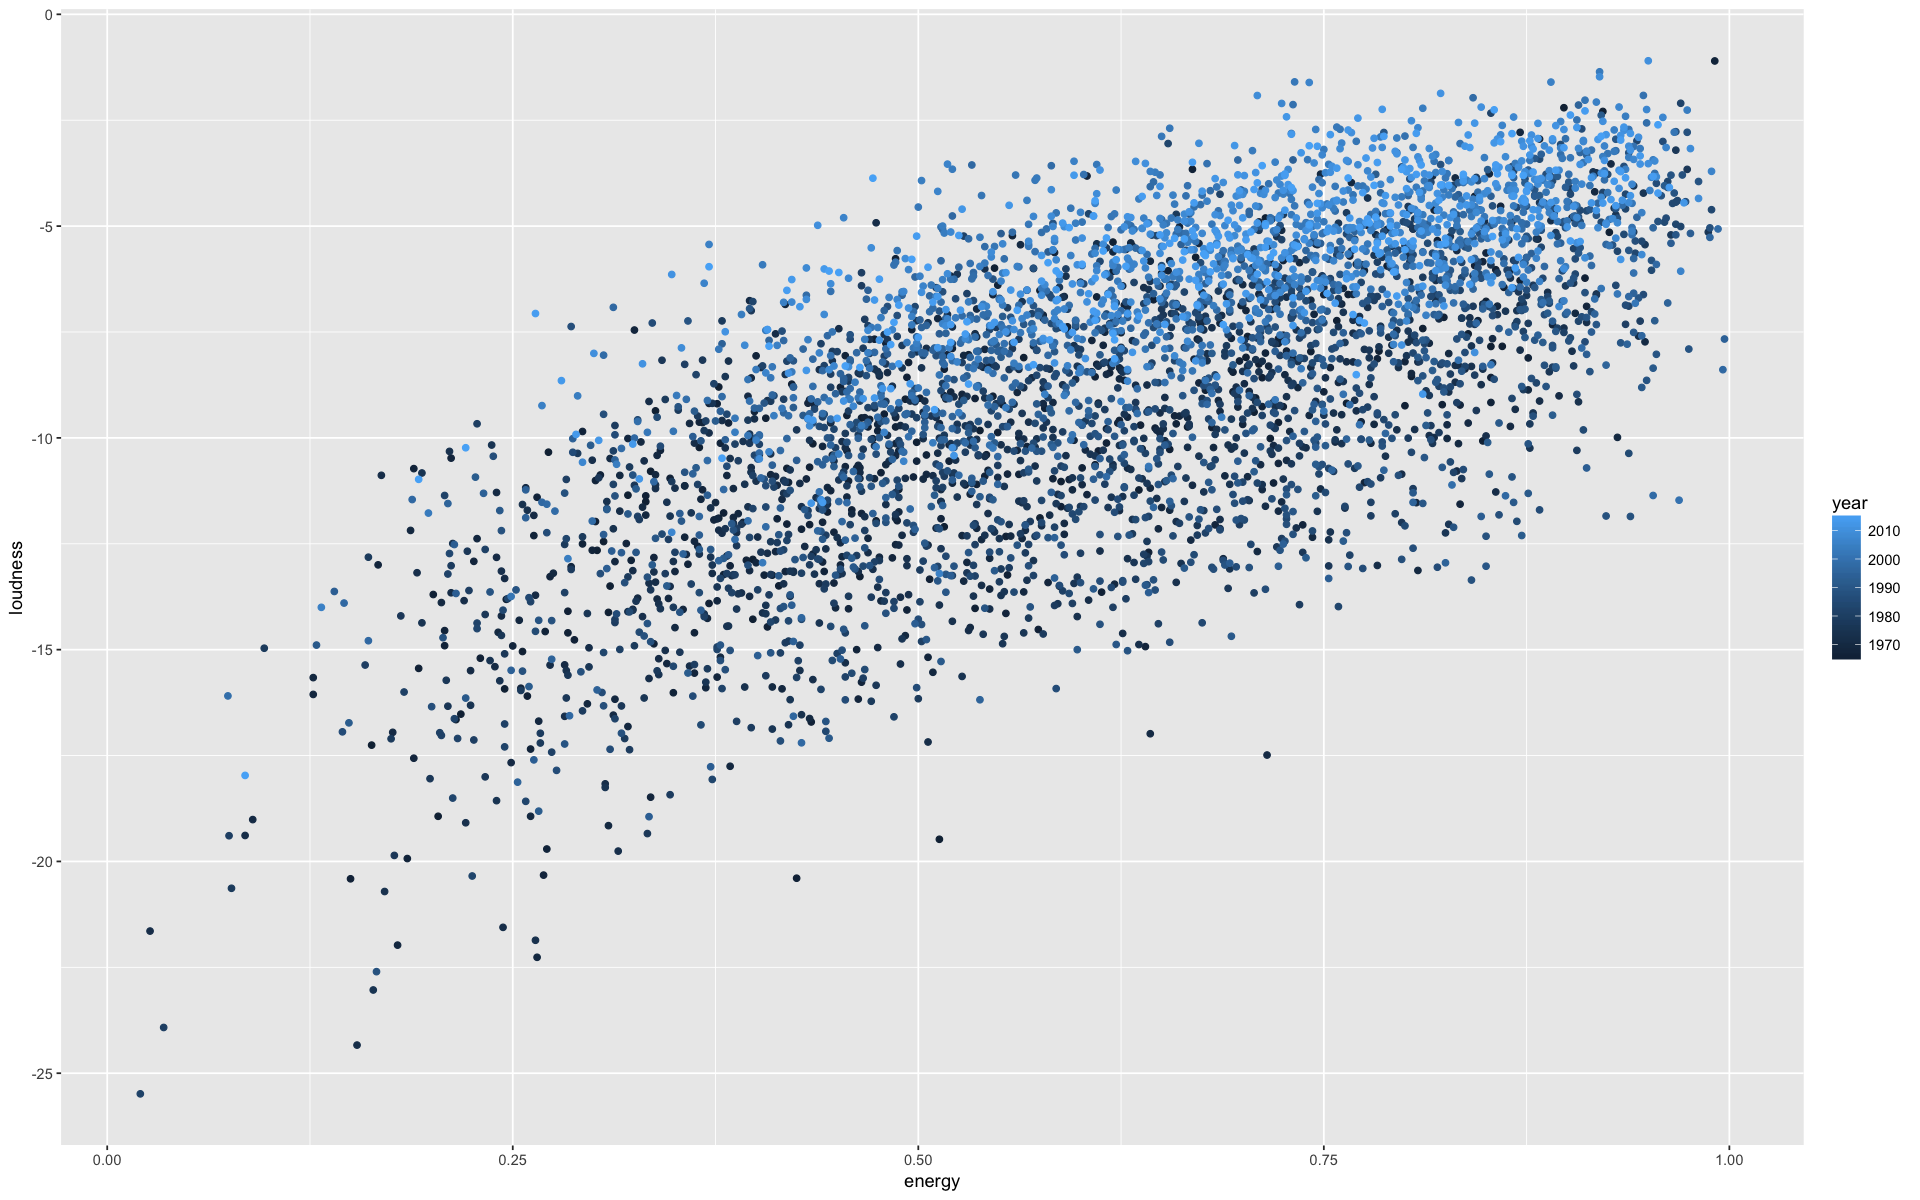

In [254]:
ggplot(df, aes(x=energy, y=loudness, color=year)) +
    geom_point() 

Warning message:
“Removed 327 rows containing missing values (geom_point).”

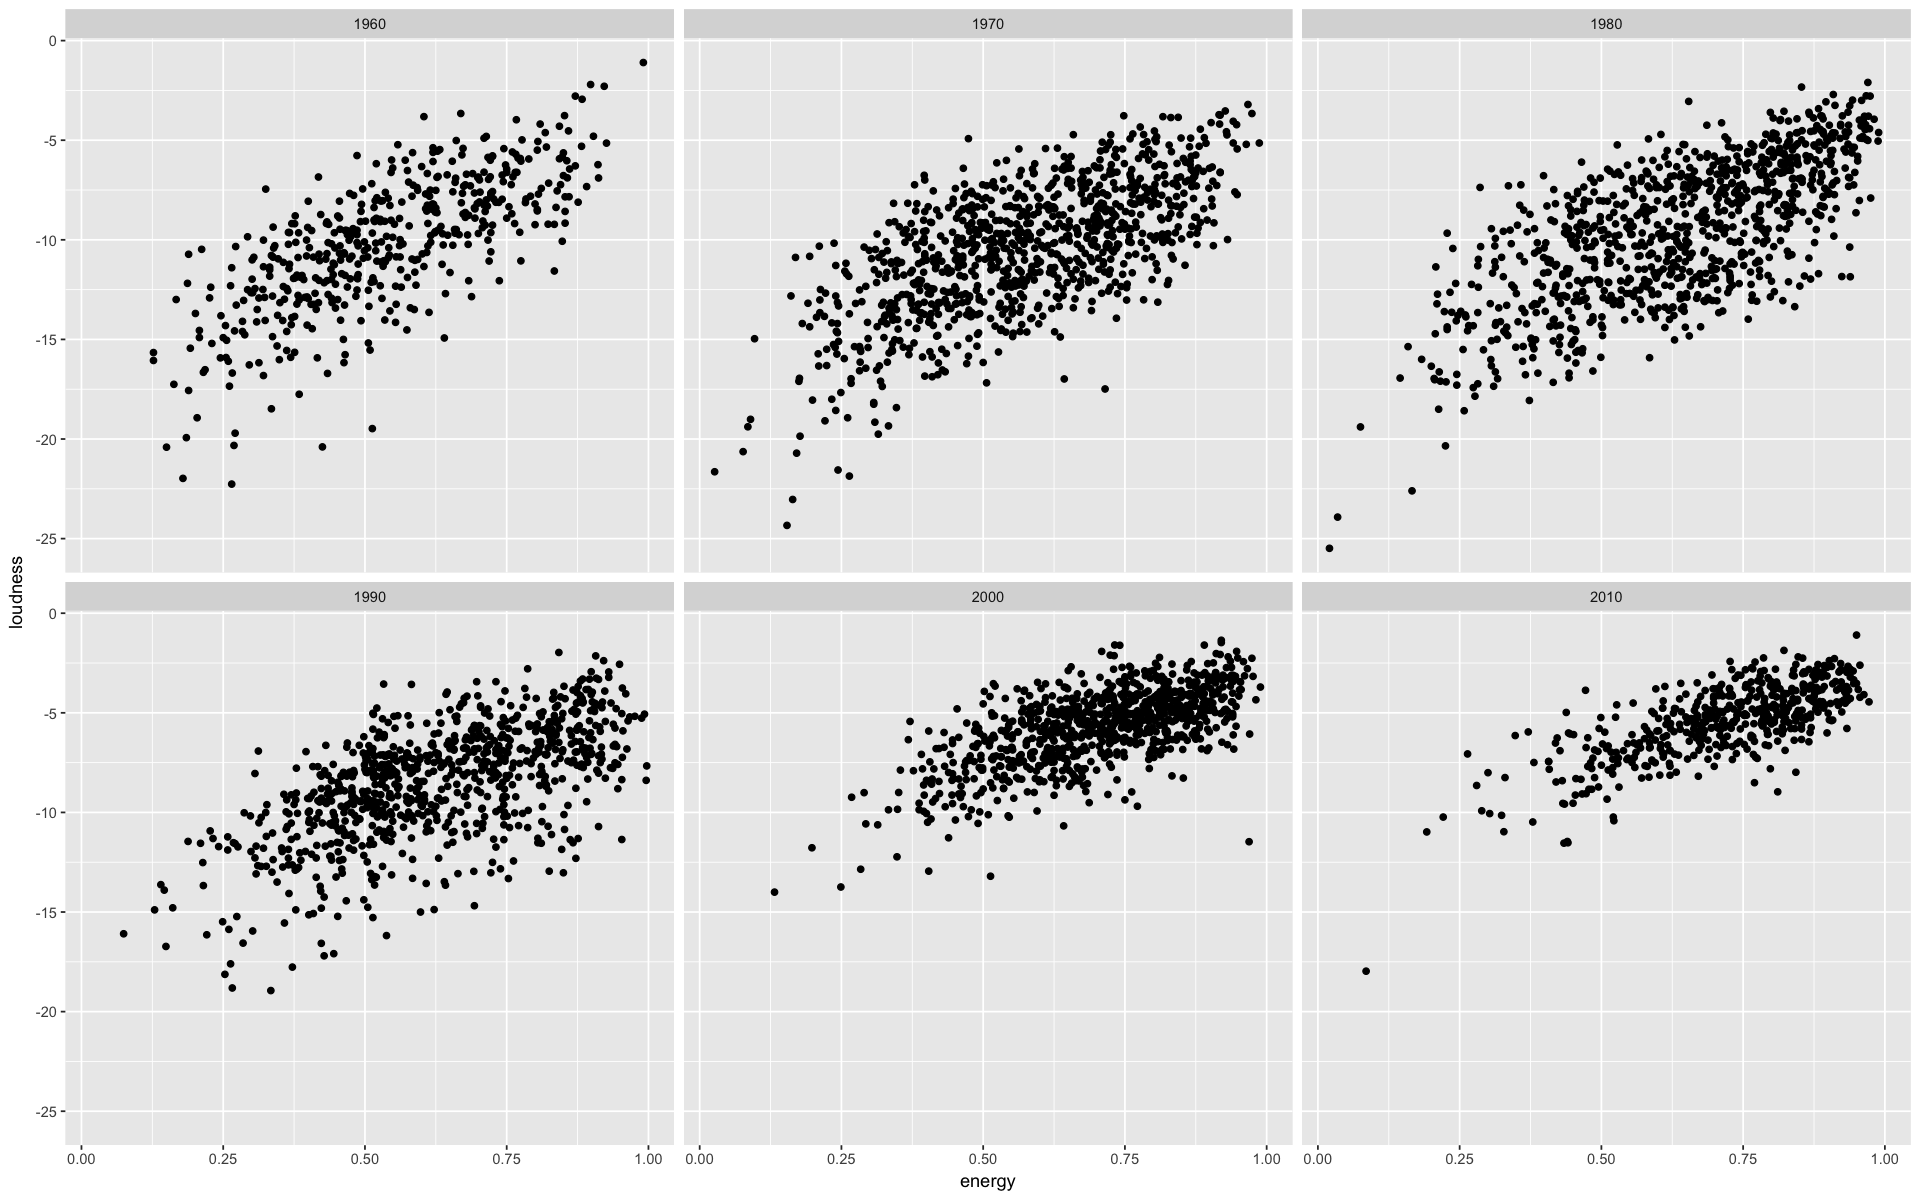

In [253]:
ggplot(df, aes(x=energy, y=loudness)) +
    geom_point() +
    facet_wrap(~ decade)